# Final ATOC REU PBC Review Challenge: Debugging

### Step 1: Import packages

In [1]:
import pandas as pd
import xarray as xarr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Read in data and convert to nc file

In [2]:
df = pd.read_csv('Dec2018Components2.csv')

In [3]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%m/%D/%Y %H:%M:%S')

In [4]:
df.set_index(df['DateTime'], inplace=True, drop=True)

In [5]:
df = df.loc[df['Speed_U']==-999,:]  # need to remove data flagged for missing values

Text(0.5, 1.0, 'Timeseries of wind speed in U direction')

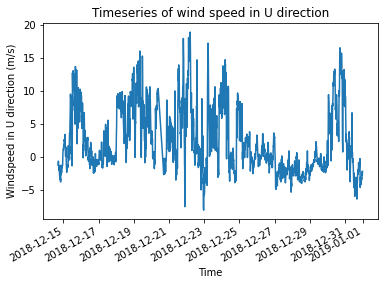

In [6]:
fig, axs = plt.subplots()
plt.plot(df['DateTime'], df['Speed_U'])
fig.autofmt_xdate()
plt.xlabel('Time')
plt.ylabel('Windspeed in U direction (m/s)')
plt.title('Timeseries of wind speed in U direction')

In [7]:
xr = xarr.Dataset.from_dataframe(df)

# Save to netCDF
xr.to_netcdf('./NewFolder/testComponentsEvenNewer.nc')

In [8]:
ds = xarr.open_dataset('testComponentsEvenNewer.nc')

### Step 3: Create a wind rose that shows a distribution of the wind speeds and wind directions

For an overview on wind roses as well as a sample python package to create them, check out this [resource](https://pypi.org/project/windrose/) 

In [9]:
### Hint: you may need to install a few new packages for the next few lines of code. Add them all here in this cell...

For our wind rose, we need to calculate the horizontal windspeed using the Pythagorean Theorem:

$speed_{horizontal} = [speed_{u}^2 + speed_{v}^2]^{1/2}$

In [10]:
ds['HorizontalSpeed'] = (ds['Speed_U']**2 + ds['Speed_V']**2)**(1/2)

For our wind rose, we also need to calculate the wind direction. Because this is an involved calculation, we are going to rely on the external libraries, [metpy](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.wind_direction.html) and [units](https://unidata.github.io/MetPy/latest/tutorials/unit_tutorial.html) to help us.

In [11]:
ds = ds.assign(dircalc = (['DateTime'], mp.wind_direction(ds.Speed_U * units.meters /units.seconds, ds.Speed_V * units.meters /units.seconds).values))

Wind turbines only operate within a range of wind speeds. Here we assume that the wind turbine will start operating at speeds greater than 4 m/s and stop operating at 15 m/s

In [12]:
ds_filtered = ds.where(((ds['HorizontalSpeed']>4) | (ds['HorizontalSpeed']<15)))

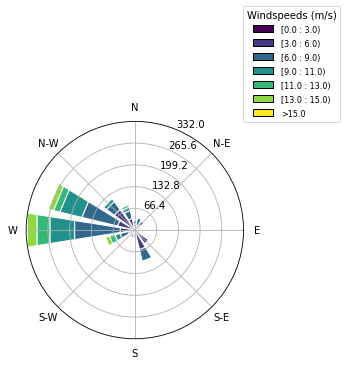

In [13]:
fig = plt.figure()
ax = plt.subplot(1, 1,1, projection="windrose")
ax.bar(ds_filtered['HorizontalSpeed'], ds_filtered['dircalc'], normed=False, edgecolor='white', bins=[0,3,6,9,11,13,15])
ax.set_legend(bbox_to_anchor=(1,1), title='Windspeeds (m/s)')

### Step 4: Calculate power according to the equation $P = 0.5C_p\rho A v^3$

The following equation is known as the *wind power equation.* The key variables in this equation are:

 - Power (W): the amount of power a wind turbine generates.
 - $C_p$ (unitless): the efficiency of the turbine. Here we assume the maximum possible efficiency, 0.52
 - $\rho$ ($kg/m^3$): the air density. Here we will assume an average value of 1.225 $kg/m^3$
 - A ($m^2$): the area swept by a wind turbine. 
     - The swept area is generally represented as A = $\pi r^2$, where $r$ is the blade length in meters. Here we assume the blade length is 132 m.
 - v ($m/s$): the horizontal windspeed
 
Note: Because wind farm developers tend to report power values in MW instead of W, we are going to divide our power in Watts (W) by $10^6$

In [14]:
ds_filtered['power'] = (1/2*0.52*1.225*np.pi*132^2*ds_filtered['HorizontalSpeed']^3)/1e6

Now we need to calculate the average power for every 30-minute period

In [15]:
ds_30 = ds_filtered.resample(time = '30min').mean()

### Step 5: Plot a scatterplot with the horizontal wind speed on the x-axis and the power on the y-axis

Text(0.5, 1.0, 'Wind Power at New Site')

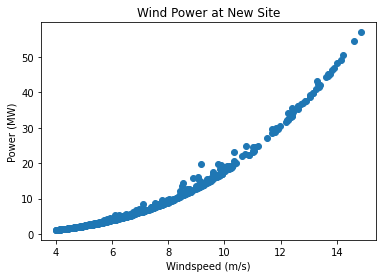

In [16]:
plt.scatter(ds_filtered['HorizontalSpeed'], ds_30['power'])
plt.xlabel('Windspeed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Wind Power at New Site')